## Logistic Regression (LogRegChoice.ipynb)

Goal: Provide evidence of the ChoiceMaker's ability to choose best hyperparameter for private logistic regression.

Good evidence: A regret plot with a variety of hyperparameters in the lead for different epsilons (and other metafeatures possibly). Jostle's algorithm competes with the best ones for all (most) cases.

Great evidence: Beating state-of-the-art private hyperparameter algorithms. This possible direction needs more thought to make sure the comparison is fair.

In [1]:
#Add the fork of sklearn to the path.
import sys, os
sys.path = ['./scikit-learn/build/lib.linux-x86_64-3.6/'] + sys.path
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from LRTools import DPLogisticRegression, DPAlg, DBTester
from LRTools import DB, DBSlicer, DBMetafeatures
from ChoiceMaker import DTChoice
import ChoiceMaker
import copy
%matplotlib inline
import pickle
import pdb
import DPrivacy as dp
import matplotlib
matplotlib.rcParams['figure.figsize'] = [16, 9]

### Flags for retraining parts of this notebook
rerun_gen_training_data: The process of slicing datasets in different ways, forming new datasets that are our training data  
rerun_gen_cms: Forming the Choicemakers on the training data which involves running logistic regression on each member in the training data  
rerun_exps: Running experiments using the Choicemakers (more detail given in the experiments section)

In [2]:
rerun_gen_training_data = False
rerun_gen_cms = [False,False,False]
rerun_exps = [False,False,False]
metadata_directory = 'log_regression_metadata/'
data_directory = 'log_regression_data/'

## Datasets
We load 3 rather famous datasets with minimal preprocessing on them.  
We chose these datasets because log_regression works well on them (which we demonstrate) and this helps us produce our evidence.

In [3]:
adult = pickle.load(open('log_regression_data/adult_preprocess.pkl', 'rb'))
magic = pickle.load(open('log_regression_data/magic_preprocess.pkl', 'rb'))
lending = pickle.load(open('log_regression_data/lending_preprocess.pkl', 'rb'))
spam = pickle.load(open('log_regression_data/spam_preprocess.pkl', 'rb'))

### Normalization and other pre-processing description
DPLogistic regression requires data to be in the unit ball. This presents a slightly unusual problem because normalizing column $X$ to be standard deviation 1 still leaves the possibility of an unbounded coordinate in $X$. I chose the least-invasive method I could think of which is just dividing out by the maximum.  
I further decided to remove columns that were less than 4% dense because I deemed them to contain too little information.

In [4]:
"""
special_normalize_and_drop:
Drops columns with fewer than percent_drop elements nonzero.
Normalizes positive columns by dividing by the max.
If column is strictly negative numbers, negates the column first
If column is a mix, then does a linear map putting max at 1 and min at 0.

Parameters:
db: input database
percent_drop: threshold for percent of nonzero elements below which the entire column is droppped

Returns:
Cleaned database.
"""
def special_normalize_and_drop(db, percent_drop):
    Xs = pd.get_dummies( db[db.columns[:-1]] )
    Xs = Xs.loc[:, (Xs == 0).sum() / Xs.shape[0] < 1-percent_drop ]
    for c in Xs.columns:
        if Xs[c].min() >= 0:
            Xs[c] = Xs[c] / Xs[c].max()
        elif Xs[c].max() <= 0:
            Xs[c] = -Xs[c] / Xs[c].min()
        else:
            rnge = Xs[c].max() - Xs[c].min()
            t = (Xs[c] - Xs[c].min()) / rnge
            Xs[c] = 2*t-1
    #Xs['const'] = np.ones(Xs.shape[0])
    Xs['TARGET'] = db[db.columns[-1]]
    return Xs

adult, magic, lending, spam = [special_normalize_and_drop(x, 0.04) for x in [adult, magic, lending, spam]]

### Code for reshaping datasets

In [5]:
"""
performs reshape_dset for each member of the Cartesian product of the arguments

Parameters:
eps_vals: List of epsilons to consider
col_vals: List of number of columns
row_vals: List of number of rows
ratios: List of ratio of 0s 
reps: number of datasets to generate for each of the above parameter choices.
prng: Pseudo-RNG
"""

def gen_tset_size_range(eps_vals, col_vals, row_vals, ratios, reps, db, prng=None):

    for c in col_vals:
        for r in row_vals:
            for e in eps_vals:
                for ratio in ratios:
                    for x in range(0, reps):
                        G = DBSlicer.reshape_dset(db, ncol=c, nrow=r, y_ratio=ratio, prng=prng)
                        last_name = G.columns[-1]
                        yield DB(G[G.columns[:-1]], G[last_name], e, True).drop(0.04).normalize()

### Constants for generating training set and for hyperparameters
Recall that a dataset in our training set is formed by operations on an input dataset with a desired epsilon, number of columns, number of rows, ratio of 0/1 values in the y column.  
eps_vals: the epsilon values to put in our training set  
col_vals: the number of columns for a dataset  
row_vals: the number of rows for a dataset  
ratios: the ratio of 0s in the y column  
num_reps: for each of the above values, generate num_reps datasets  

C_list: hyperparameters to consider  
alg_list: algorithms for those hyperparameters

In [6]:
eps_vals = [1.0, 3.0, 5.0, 7.0, 10.0]
col_vals = np.arange(2, 20, 3)
row_vals = [100, 180, 300, 600, 1000, 2000, 4000]
ratios = [0.15, 0.3, 0.5, 0.7, 0.85]
num_reps = 2
C_list = [0.1, 0.4, 0.7, 1.0, 1.8, 2.5, 7.5]
alg_list = lambda: dict([(str(x), DPAlg(C=x)) for x in C_list])

"""A convenient way to call gen_tset_size_range"""
def split_db(db, prng=None):
    return gen_tset_size_range(eps_vals, col_vals, row_vals, ratios, num_reps, db, prng)

### Calling the generation function using the retrain flags

In [7]:
prng = np.random.RandomState(12345)
if rerun_gen_training_data:
    adult_data = list(split_db(adult, prng))
    lending_data = list(split_db(lending, prng))
    magic_data = list(split_db(magic, prng))
    spam_data = list(split_db(spam, prng))
    pickle.dump(adult_data, open(data_directory + 'adult_slices.pkl', 'wb'))
    pickle.dump(lending_data, open(data_directory + 'lending_slices.pkl', 'wb'))
    pickle.dump(magic_data, open(data_directory + 'magic_slices.pkl', 'wb'))
    pickle.dump(spam_data, open(data_directory + 'spam_slices.pkl', 'wb'))
else:
    adult_data = pickle.load(open(data_directory + 'adult_slices.pkl', 'rb'))
    lending_data = pickle.load(open(data_directory + 'lending_slices.pkl', 'rb'))
    magic_data = pickle.load(open(data_directory + 'magic_slices.pkl', 'rb'))
    spam_data = pickle.load(open(data_directory + 'spam_slices.pkl', 'rb'))

## A prerequisite for good evidence: Is high performance ever possible on each dataset?
If high values of epsilon fail to produce good values for all hyperparameters, then we won't be able to easily establish any relationship between how Jostle is doing versus how the best algorithm is doing because they will all be doing "badly".  

The logistic_test function does just this; first, it prints the baseline performance (epsilon=infinity) and then for each epsilon value from 1 to 10 prints whether the r^2 of private regression gets within 90% of this goal. What we see is that eventually, a big enough value of epsilon allows us to get close to the non-private value which I consider a "good" number.

Recall that performance is measured as r^2. An r^2 of 0.2 is not too great, but still indicates that something nontrivial is happening. The r^2 for lending_data is suspiciously low so the results for that dataset will not constitute our strongest evidence. We can still use this dataset in our choicemaker, however.

Note that I test on the last element of each training dataset, which is not an original dataset, but the last dataset in the transformations of the original dataset. This dataset is among the most expressive of the transformed datasets as it has thousands of rows, tens of columns, etc. Thus, its performance should be among the highest. Indeed, if you test on an earlier element, the performance tends to be lower. It may be impeding some of our results that a large fraction of the datasets do have low performance even at high epsilon

In [12]:
loc=-1

In [13]:
DBTester.logistic_test(adult_data[loc].X, adult_data[loc].y, adult_data[loc].get_norm()*2, 1, tol= 0.9)

Baseline: 0.164218
epsilons: 
eps = 1.00: 0.04 (No); eps = 2.00: 0.14 (No); eps = 3.00: 0.15 (No); eps = 4.00: 0.15 (Yes); eps = 5.00: 0.13 (No); eps = 6.00: 0.17 (Yes); eps = 7.00: 0.15 (Yes); eps = 8.00: 0.16 (Yes); eps = 9.00: 0.17 (Yes); eps = 10.00: 0.17 (Yes); 

In [10]:
DBTester.logistic_test(lending_data[loc].X, lending_data[loc].y, lending_data[loc].get_norm() * 2, 1, tol=0.9)

Baseline: 0.029392
epsilons: 
1.00 No; 2.00 No; 3.00 No; 4.00 No; 5.00 No; 6.00 No; 7.00 Yes; 8.00 Yes; 9.00 Yes; 10.00 Yes; 

In [10]:
DBTester.logistic_test(magic_data[loc].X, magic_data[loc].y, magic_data[loc].get_norm() * 2, 1, tol=0.9)

Baseline: 0.236449
epsilons: 
1.00 No; 2.00 Yes; 3.00 Yes; 4.00 Yes; 5.00 Yes; 6.00 No; 7.00 Yes; 8.00 Yes; 9.00 Yes; 10.00 Yes; 

In [17]:
DBTester.logistic_test(spam_data[loc].X, spam_data[loc].y, spam_data[loc].get_norm() * 2, 100, tol=0.75)

Baseline: 0.315237
epsilons: 
eps = 1.00: -0.24 (No); eps = 2.00: -0.23 (No); eps = 3.00: -0.14 (No); eps = 4.00: -0.25 (No); eps = 5.00: -0.21 (No); eps = 6.00: -0.20 (No); eps = 7.00: -0.55 (No); eps = 8.00: -0.71 (No); eps = 9.00: -0.01 (No); eps = 10.00: 0.15 (No); 

## Running the Choicemakers

In [16]:
if rerun_gen_cms[0]:
    acm = DTChoice(adult_data, DBMetafeatures(), alg_list())
    pickle.dump(acm, open(metadata_directory+'adult_cm.pkl', 'wb'))
else:
    acm = pickle.load(open(metadata_directory+'adult_cm.pkl', 'rb'))

In [17]:
if rerun_gen_cms[1]:
    lcm = DTChoice(lending_data, DBMetafeatures(), alg_list())
    pickle.dump(lcm, open(metadata_directory+'lending_cm.pkl', 'wb'))
else:
    lcm = pickle.load(open(metadata_directory+'lending_cm.pkl', 'rb'))

In [18]:
if rerun_gen_cms[2]:
    mcm = DTChoice(magic_data, DBMetafeatures(), alg_list())
    pickle.dump(mcm, open(metadata_directory+'magic_cm.pkl', 'wb'))
else:
    mcm = pickle.load(open(metadata_directory+'magic_cm.pkl', 'rb'))

### Simple test of CM validity:

We run another test of validity to make sure that the data we've collected will provide good evidence.  
Before, we checked a specific algorithm on a specific database just to see if decent r^2 is possible. We still need to see if there are a variety of algorithms which perform best.

Ideally, we'd expect to see, for all datasets, an algorithm that does well on that dataset.
In practice, we'd like this to be true for a large fraction of the datasets.
We'd also like to know, for each algorithm, how often it performs really well compared to the other algorithms. We'd want each algorithm to have its good regime.

In [92]:
"""
cm_simple_analysis: Evaluates choicemaker validity by printing how many databases had 
r^2 above a threshold and the average r^2 for each algorithms.
Then, prints for which fraction of databases each algorithm performed the best and
two histograms: one printing the performance gap between an algorithm and the second-best,
and one printing the performance gap between an algorithm and the median algorithm, for each
algorithm when it performs the best.

parameters:

cm: Choicemaker
thresh: threshold to consider "decent" r^2.
"""

def cm_simple_analysis(cm, thresh, clamp=(0,0.25)):
    R = cm.regrets.copy()
    R = R[R.max(axis=1) > thresh]
    pct = R.shape[0] / cm.regrets.shape[0]
    print("%0.2f of the databases have significant r^2" % (pct*100) )
    print("Average performance by algorithm:")
    print(R.mean(axis=0))
    print("Fraction of time that each algorithm performed the best")
    print(pd.value_counts(R.idxmax(axis=1)) / R.shape[0])
    maxes = R.idxmax
    maxes = R.idxmax(axis=1)
    M = R.values.copy()
    M.sort(axis=1)
    mid = M.shape[1] // 2
    dist = (M[:, -1] - M[:, -2])
    dist2 = (M[:, -1] - M[:, mid])
    L = len(maxes.unique())
    num_cols = L - L//2
    for i, m in enumerate( maxes.unique() ):
        ax = plt.subplot(2, num_cols, i+1)
        ax.hist(dist[maxes == m], bins=20, range=clamp, label='vs. 2nd best', alpha=0.7)
        ax.hist(dist2[maxes == m], bins=20, range=clamp, label='vs median', alpha=0.7)
        ax.set_title(m)
    plt.legend()

38.19 of the databases have significant r^2
Average performance by algorithm:
0.1   -0.027534
0.4    0.016335
0.7    0.025168
1.0    0.020945
1.8   -0.004706
2.5   -0.059342
7.5   -0.235537
dtype: float64
Fraction of time that each algorithm performed the best
1.8    0.243142
2.5    0.220698
1.0    0.195761
0.7    0.144638
7.5    0.072319
0.4    0.069825
0.1    0.053616
dtype: float64


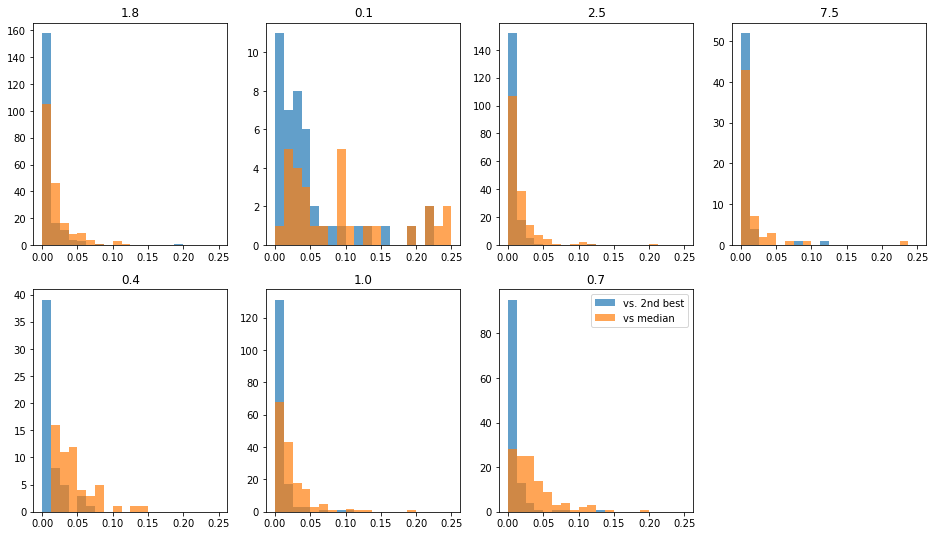

In [93]:
#Based on first experiment, thresh = 0.02 seems to be decent for this database.
cm_simple_analysis(lcm, thresh=0.02)

50.62 of the databases have significant r^2
Average performance by algorithm:
0.1    0.022083
0.4    0.129859
0.7    0.145748
1.0    0.154320
1.8    0.136741
2.5    0.085983
7.5   -0.065245
dtype: float64
Fraction of time that each algorithm performed the best
2.5    0.261524
1.8    0.252117
7.5    0.181562
1.0    0.117592
0.7    0.099718
0.4    0.046096
0.1    0.041392
dtype: float64


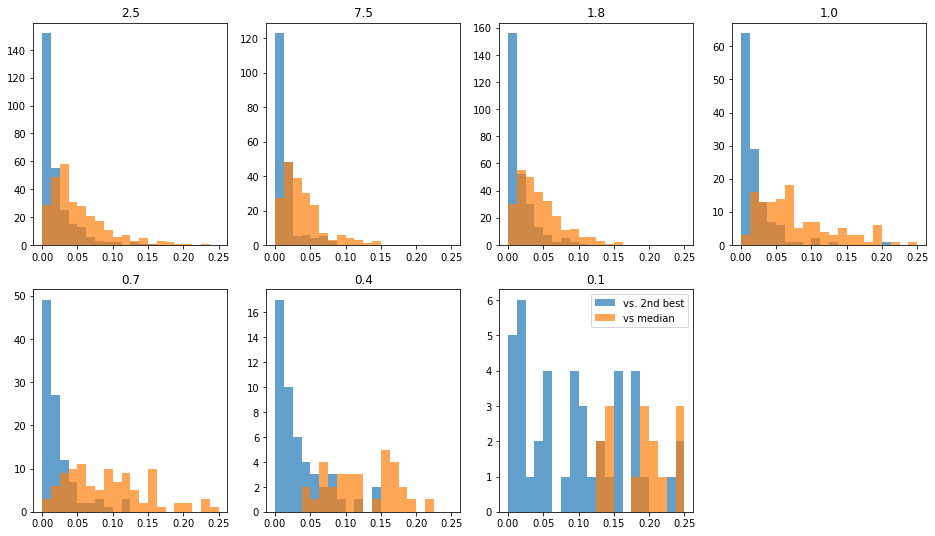

In [94]:
#Based on first experiment, thresh = 0.1 seems to be decent for this database.
cm_simple_analysis(acm, thresh=0.10)

50.57 of the databases have significant r^2
Average performance by algorithm:
0.1   -0.014209
0.4    0.094150
0.7    0.109100
1.0    0.127912
1.8    0.134946
2.5    0.104999
7.5   -0.030972
dtype: float64
Fraction of time that each algorithm performed the best
7.5    0.348399
2.5    0.271186
1.8    0.174200
1.0    0.125235
0.4    0.038606
0.7    0.032015
0.1    0.010358
dtype: float64


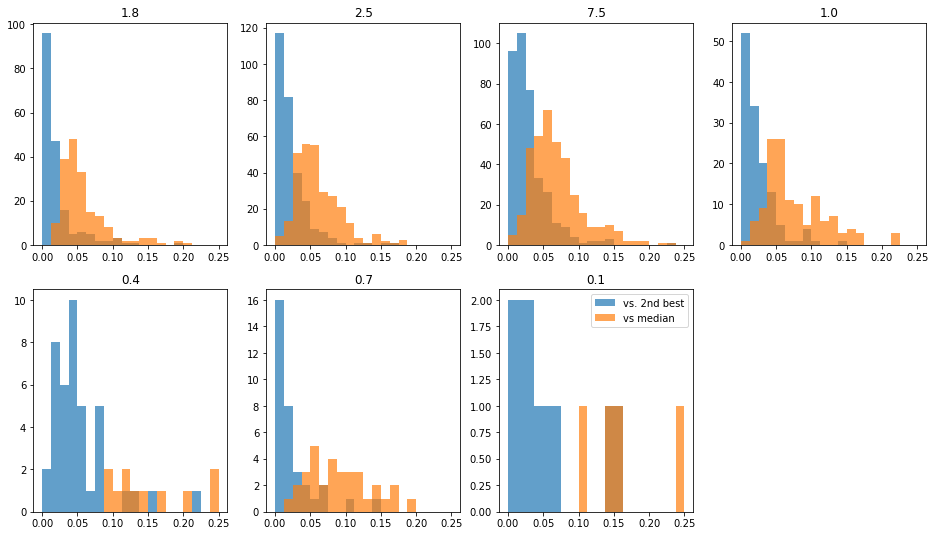

In [95]:
#Based on first experiment, thresh = 0.1 seems to be decent for this database.
cm_simple_analysis(mcm, thresh=0.1)

## The full experiments

For training set i (consisting of slices of input database i), take the knowledge known in the choicemakers that aren't i, forming a bigger choicemaker (with a new decision rule). Use training set i as the "testing" set for this choicemaker, meaning we run the choicemaker on each dataset and compare it to the algorithm runs contained in choicemaker i. We would like to see two things to establish "good evidence" that the choicemaker is working well:  

There are a number (at least two) of algorithms which perform better than the others for many regimes, and...  
For most of the regimes, the choicemaker performs about as well as the best one (with a small penalty of course, because we are using some of the epsilon to choose).

### Forming the bigger choicemakers used in the experiments...

In [232]:
"""
{dbname}_test_cm contains all databases which are not named {dbname} as training data.
"""

adult_test_cm = DTChoice(lending_data + magic_data, DBMetafeatures(), 
                       alg_list(),
                       1.0-pd.concat((lcm.regrets, mcm.regrets), ignore_index=True))
adult_test_cm.model = tree.DecisionTreeClassifier(min_samples_leaf=10, max_depth=3)
adult_test_cm.retrain_model()

lending_test_cm = DTChoice(adult_data + magic_data, DBMetafeatures(), 
                       alg_list(),
                       1.0-pd.concat((acm.regrets, mcm.regrets), ignore_index=True))
lending_test_cm.model = tree.DecisionTreeClassifier(min_samples_leaf=10, max_depth=3)
lending_test_cm.retrain_model()

magic_test_cm = DTChoice(adult_data + lending_data, DBMetafeatures(), 
                       alg_list(),
                       1.0-pd.concat((acm.regrets, lcm.regrets), ignore_index=True))
magic_test_cm.model = tree.DecisionTreeClassifier(min_samples_leaf=10, max_depth=3)
magic_test_cm.retrain_model()

### Running the choicemakers

In [97]:
"""
run_cm: Gets the Choicemaker's decision for a database, gets the error of the algorithm, and returns them

parameters:

data: list of databases
cm: choicemaker.
"""
def run_cm(data, cm):
    algos = []
    rsq = []
    for db in data:
        alg = cm.choose(db, 0.2)
        algos.append(alg.name)
        rsq.append(alg.error(db))
    return (algos, rsq)

In [98]:
if rerun_exps[0]:
    lending_algos, lending_rsq = run_cm(lending_data, lending_test_cm)
    pickle.dump(lending_rsq, open(metadata_directory+'lending_exp1.pkl', 'wb'))
else:
    lending_rsq = pickle.load(open(metadata_directory+'lending_exp1.pkl', 'rb'))

In [99]:
if rerun_exps[1]:
    adult_algos, adult_rsq = run_cm(adult_data, adult_test_cm)
    pickle.dump(adult_rsq, open(metadata_directory + 'adult_exp1.pkl', 'wb'))
else:
    adult_rsq = pickle.load(open(metadata_directory+'adult_exp1.pkl', 'rb'))

In [100]:
if rerun_exps[2]:
    magic_algos, magic_rsq = run_cm(magic_data, magic_test_cm)
    pickle.dump(magic_rsq, open(metadata_directory + 'magic_exp1.pkl', 'wb'))
else:
    magic_rsq = pickle.load(open(metadata_directory + 'magic_exp1.pkl', 'rb'))

### Making graphs

For each testing dataset list, we combine the choicemaker's errors with the errors of each algorithm which happen to be located in the choicemaker for that dataset.

In [101]:
lending_errors = lcm.regrets.copy()
lending_errors['cm'] = lending_rsq
adult_errors = acm.regrets.copy()
adult_errors['cm'] = adult_rsq
magic_errors = mcm.regrets.copy()
magic_errors['cm'] = magic_rsq

We clean the data and aggregate it to produce our plots.
Some of the testing databases are not suitable for algorithm comparison because no algorithm does well on them. We drop such datasets in the cleaning phase. Furthermore, we aggregate the data by selected metafeatures.

In [139]:
"""
clean_and_combine_data: 

Parameters:
errors: Algorithm errors (rows are databases, columns are algorithms)
db_metas: database metafeatures (rows are databases, columns are algorithms)
group_by_metas: metafeatures to group the errors by. sub-list of ['nrow', 'ncol', 'eps', 'numy']
aggregation: 'median' or 'mean'; how to aggregate the errors within each group.
threshold: Threshold for the best algorithm's performance below which the database is dropped from our results

Returns:

"""

def clean_and_combine_data(errors, db_metas, group_by_metas, aggregation = 'median', threshold = 0):
    idxs = ~np.all(errors < 0, axis=1)
    db_errors_and_metas = pd.concat((errors, db_metas[group_by_metas]), axis=1)
    filtered_db_error_groups = db_errors_and_metas.loc[idxs, :].groupby(group_by_metas)
    if aggregation == 'median':
        return filtered_db_error_groups.median()
    else:
        return filtered_db_error_groups.mean()

We define two plotting functions, each allowing us to view the relationship between 1 or 2 metafeatures and algorithm performance for each algorithm. Recall that our goal for "good evidence" is to find multiple metafeature regimes where one algorithm outperforms the others significantly and the Choicemaker is performing just as well.

In [300]:
"""
do_linegraph: Plots algorithm performance for each algorithm vs. a metafeature.

Parameters:

tst: a pandas dataframe with rows indexed by metafeatures and columns indexed by the algorithm.
ylim: limits on the y axis.
styles: List containing line styles to pass to matplotlib for each algorithm.
"""
def do_linegraph(tst, ylim, styles=None):
    if styles is None:
        styles = ['o-'] * tst.shape[1]
    fig, axis=plt.subplots()
    for i in range(tst.shape[1]):
        col = tst.columns[i]
        axis.plot(np.array(tst[col].index), tst[col], styles[i], label=col)
    #axis.plot(tst.index, tst['cm'], 'o-', label='C_reg')
    axis.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=4)
    axis.set_ylabel('R squared')
    axis.set_ylim(ylim)
    axis.set_title('R squared Jostle, competitor, and baseline vs %s' % tst.index.name)
    axis.set_xlabel(tst.index.name)
    
"""
do_imggraph: Plots algorithm performance for two metafeatures as an image; rows of the image are the first 
metafeature and columns are the second. Color hue/brightness correspond to algorithm performance.
Makes an image for each algorithm.

Parameters:

tst: a pandas dataframe with rows indexed with a pandas MulitIndex containing two levels: metafeature 1
and metafeature2. The first level corresponds to the columns of the image and the second corresponds
to the rows of the image. Columns of tst are indexed by algorithm.

vmin: Minimum performance value at which to start chromatic scale.

vmax: Maximum performance at which to start chromatic scale.

ncol: Number of columns to put in the 
"""
def do_imggraph(tst, vmin, vmax, nrow=2):
    L = tst.shape[1]
    ncol = 1+(L-1)//nrow
    for c, col in enumerate(tst.columns):
        ax = plt.subplot(nrow, ncol, c+1)
        shape = tst.index.levshape
        im = ax.imshow(np.array( tst[col] ).reshape(shape), vmin=vmin, vmax=vmax)
        x_col = tst.index.levels[1]
        y_col = tst.index.levels[0]
        ax.set_yticklabels([''] + list(y_col))
        ax.set_xticklabels([''] + list(x_col))
        for i, v in enumerate(x_col):
            for j, u in enumerate(y_col):
                ax.text(i, j, "%0.2f" % tst.loc[(u,v), col], ha='center', va='center', color='w')
        ax.set_title("Algorithm %s" % str(col))
        ax.set_xlabel(tst.index.levels[1].name)
        ax.set_ylabel(tst.index.levels[0].name)
    plt.tight_layout()

##### First Result:
For $\epsilon = 1$, the best algorithms, 0.1 and 0.4, perform the best, and Jostle is much closer to them than the others. For $\epsilon = 3$, Jostle has phased out much of the use of 0.1. For $\epsilon=5$ and beyond, Jostle is  following 1.0, 1.8, and 2.5 a super-majority of the time.

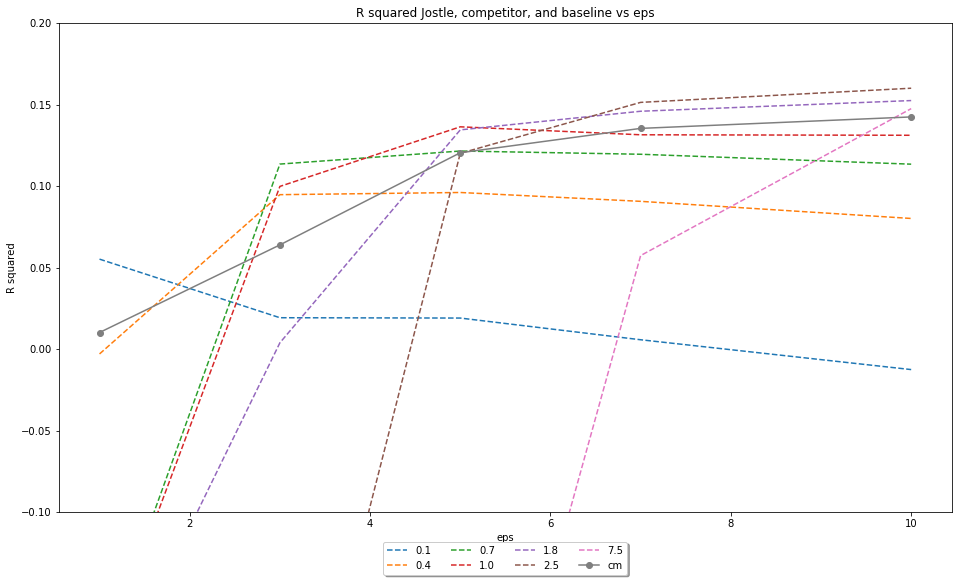

In [296]:
e_adult_eps = clean_and_combine_data(adult_errors, acm.X, ['eps'], aggregation='median')
styles = ['--'] * (e_adult_eps.shape[1]-1) + ['o-']
do_linegraph(e_adult_eps, [-0.1, 0.2], styles)

The lending dataset demonstrates this to a lesser extent

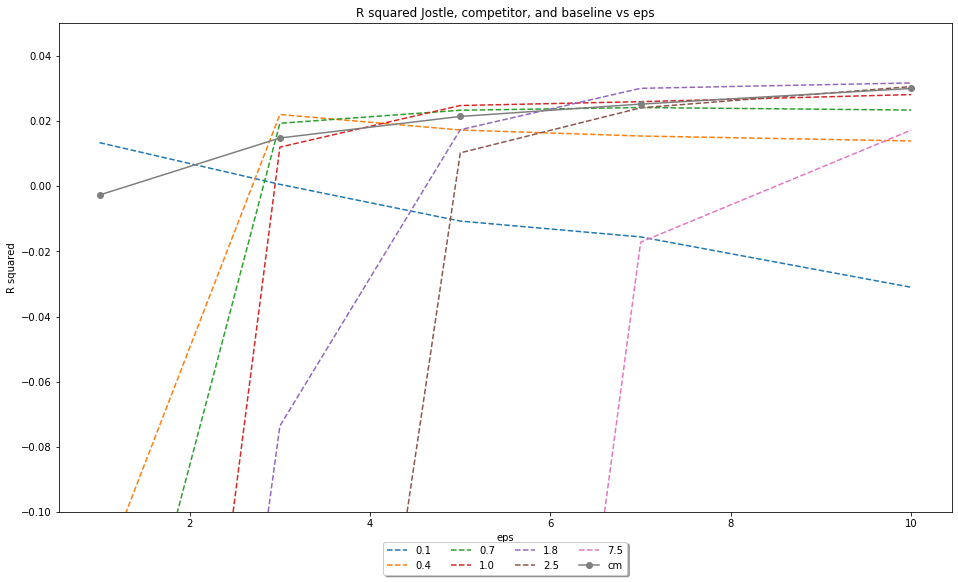

In [287]:
e_lending_eps = clean_and_combine_data(lending_errors, lcm.X, ['eps'], aggregation='median')
styles = ['--'] * (e_lending_eps.shape[1]-1) + ['o-']
do_linegraph(e_lending_eps, [-0.1, 0.05], styles)

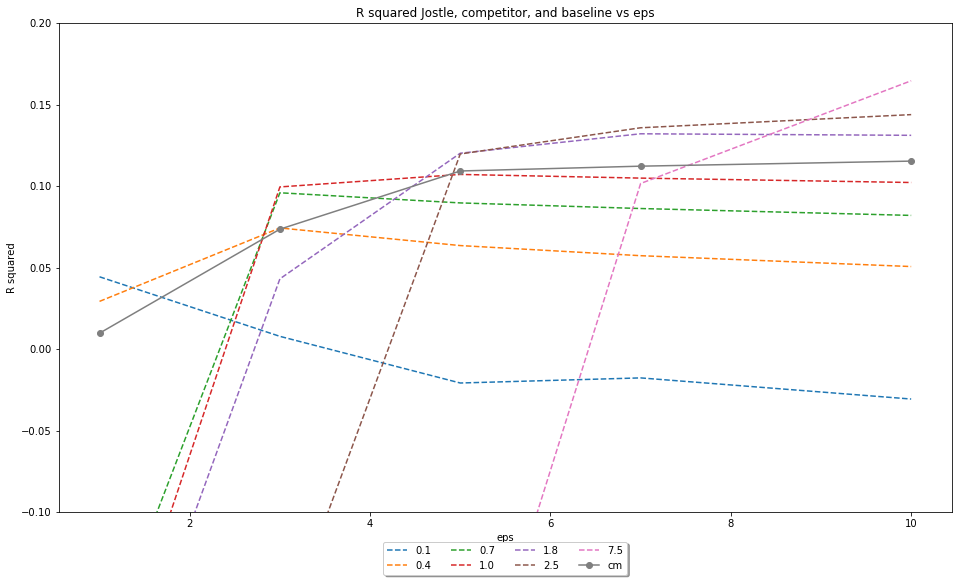

In [298]:
e_magic_eps = clean_and_combine_data(magic_errors, lcm.X, ['eps'], aggregation='median')
styles = ['--'] * (e_magic_eps.shape[1]-1) + ['o-']
do_linegraph(e_magic_eps, [-0.1, 0.2], styles)

Regime where 0.1 does well: High nrow, eps. cm clearly listens to 0.1, 0.4 here. Then, it starts moving 

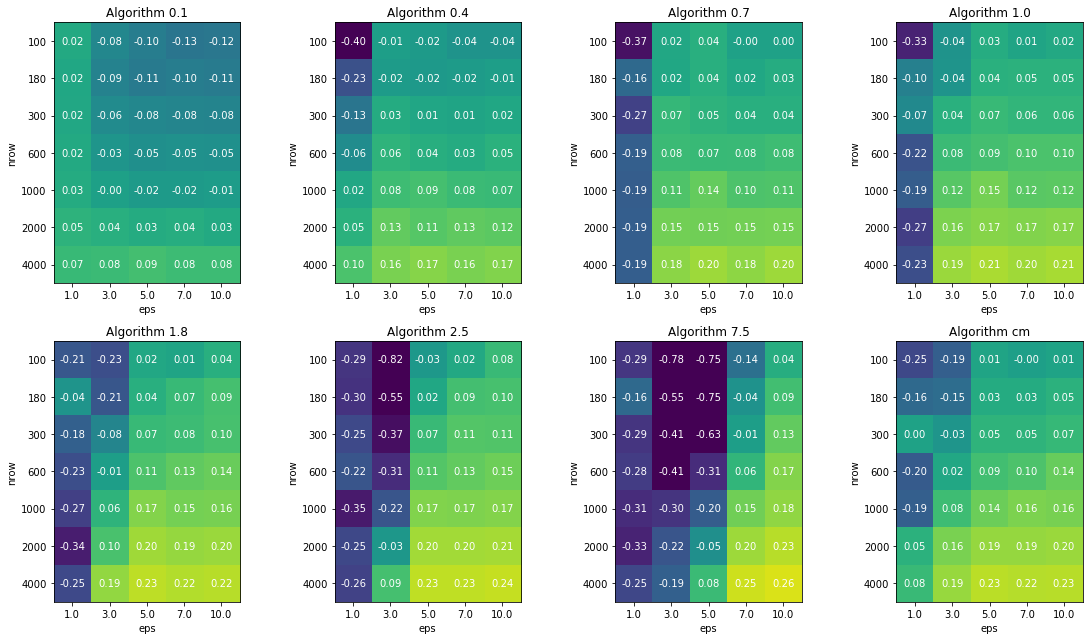

In [303]:
e_magic2 = clean_and_combine_data(magic_errors, mcm.X, ['nrow', 'eps'], aggregation='median')
do_imggraph(e_magic2, vmin=-0.4, vmax=0.3)

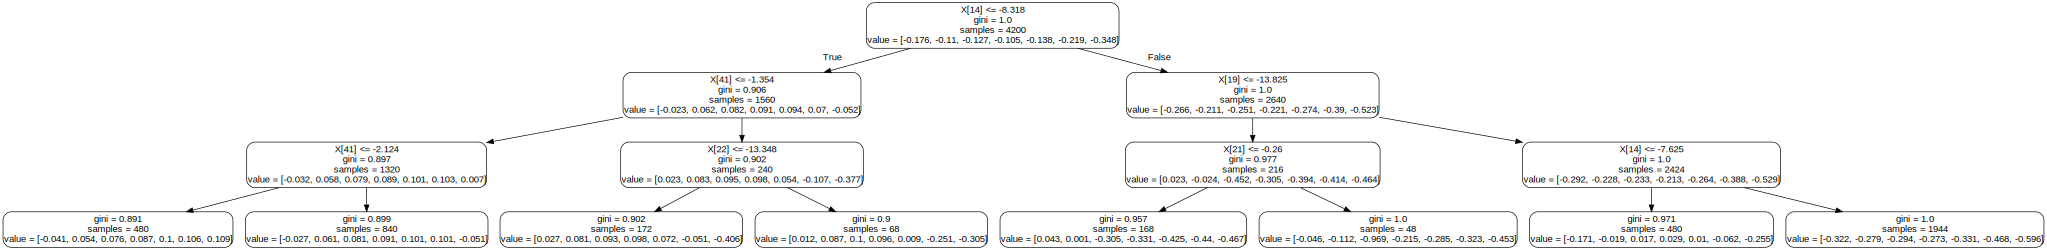

In [239]:
adult_test_cm.print_tree()

In [248]:
adult_test_cm.print_arith_coef(14-4)

' / nrow*eps'

Minor issues I want to change:  
Change metafeature from "number of points classified as 1" to "percent of points classified as 1"  
Remove from DTChoice code the addition of X dataframe to decision tree training method.  

Bigger issues I want to change:  
Rerun the choicemaker with more low values of epsilon.  
Clean up choicemaker data better  
Better datasets with significant r^2. Get test_1 to work!
Parallelize training